# 서울시 부동산 실거래가 분석하기

# 1. 모듈 불러오기 

In [6]:
from IPython.display import Image


# 데이터 전처리
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 선형 회귀 모델
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 정규화 모델
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV ,RidgeCV, ElasticNetCV
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 부스팅 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import torch

# 데이터 시각화 패키지
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm

# 한글 폰트 설정 
plt.rc('font', family='Malgun Gothic')

# 2. 데이터 불러오기

## 데이터 구조
- 데이터 : 국토교통부, 통계청, 네이버 부동산, 구글맵, 부동산 114 등
- 관측치 개수 : ***개
- 변수 개수 : ***개 

## 설명 변수 (원인 : 예측값을 설명할 수 있는 변수)

### 구조적 특성
- 단지명(csv)
- 전용 면적 (csv) : 단지명이랑 전용 면적을 줄기로 파생 데이터를 붙여야됨 
- 건축년도 (csv)
- 층 수 (csv) 
- 방 수 (m. 네이버 부동산)
- 화장실 수 (m. 네이버 부동산) : 기존의 부동산 가격을 분석했던 헤도닉 모형에 공통적으로 포함되어 있음
- 난방 (m.네이버 부동산) : 2008년 원두환·김형건(난방 방식에 따른 아파트 가격 변화 분석) 참조

 
### 환경적 특성
- 크기 (총 세대 수, 동 수) (m.네이버 부동산) : 도시경제학에서 군집 효과의 크기를 의미
- 평균 주차 가능 대수 (m.네이버 부동산) : 아파트 단지 내 가구당 주차수요가 증가하면서 점차 중요한 요인으로 고려되고 있음.
- 단지 내 최고층의 높이 (m.네이버 부동산) : 단지 내의 조경
- 최저층의 높이 (m.네이버 부동산)
- 건폐율 (m.네이버 부동산) : 건축면적에 대한 대지면적의 비율
- 용적률 (m.네이버 부동산) : 총면적의 대지면적에 대한 비율 -> 재건축 시 기대할 수 있는 수익과 직접적인 연관

### 입지적 특성
- 주요 시설과의 거리 (m.네이버 부동산) : 버스, 지하철, 학교, 어린이집, 유치원, 마트, 편의점 ,세탁소, 은행
- 병원은 1km 이내가 5%밖에 안되서 의사/환자수로 대체 요망

### 정책 반영
- 자잘한 대책들 제외하고 LTV, DTI / 종소세, 양도세 보유세 건드린 것들만 반영



## 반응 변수 (결과 : 예측하고자 하는 값)
- 매매가격 (국토 교통부 아파트 매매 실거래가)

-  ComplexName(건물명) : object        
-  Area(전용면적) : float64       
-  Floor(층) : int64         
-  Construct(건설년도) : int64         
-  Addr(주소) : object        
-  gu(구 코드) : int64                        =>          string으로 변경 후 label encoding       
-  dong(동 코드) : int64              
-  apt(아파트 코드) : int64         
-  household(총 세대 수) : object        
-  floor_low(최저층) : int64         
-  floor_top(최고층) : int64         
-  parking(총 주차 수) : object        
-  floor_area(용적) : float64       
-  building_cover(건폐 : float64       
-  construction(건설사) : object             =>          (순위 개념 도입?)  삭제? 
-  heating : object                          =>          인코딩
-  bus : object                           
-  subway : object                           =>          역세권 개념 : 500m 이내 
-  child : object        
-  preschool : object                        =>          유치원/어린이집/학교 
-  school : object        
-  parking_lot : object        
-  market : object        
-  convenience : object                      =>          편세권 
-  laundry : object        
-  bank : object        
-  hospital : object                         =>          병원은 구별로 1인당 의사로 하는게 좋을듯 (병원의 거리가 너무 멀어서) / 삭제.?
-  contract : datetime64[ns] :              
-  policy_1 : int64         
-  policy_2 : int64         
-  policy_3 : int64         
-  policy_4 : int64         
-  policy_5 : int64         
-  policy_6 : int64         
-  policy_7 : int64         
-  policy_8 : int64         
-  policy_9 : int64         
-  policy_10 : int64                         

# 3. 탐색적 데이터 분석 및 데이터 전처리
- X : 독립변수, 예측변수, 입력변수
- y : 종속변수, 반응변수, 출력변수

## 부동산 데이터 수집 
- 네이버 부동산 (pc) : https://new.land.naver.com/complexes/22853?ms=37.5085491,127.0104349,17&a=APT&b=A1&e=RETAIL&ad=true
- 네이버 부동산 (모바일) : https://m.land.naver.com/complex/info/22853?ptpNo=1
- complex 다음 숫자가 아파트 번호 코드
- 아파트 번호를 리스트화해서 for 반복문을 통해 크롤링
- 모바일 데이터는 html 파싱하는 방식으로 크롤링

### 모바일 데이터로 얻을 수 있는 데이터의 정보 (object, float, int)

- 세대수
- 최저/최고층  
- 총주차대수 : 총주차대수/세대수로 수정 요망
- 사용승인일
- 용적률
- 건폐율
- 건설사
- 난방
- 면적 : 평수로 바꿀 예정
- 주변 편의시설/1km 이내 : 병원은 구를 기준 삼아 의사/인구수 비율로 수정 요망
- 주변 대중교통 (ex. 지하철 7 , 버스 50) : 역세권 개념을 정의해야될듯(500m?)

In [7]:
df17=pd.read_csv('data/아파트실거래가_17.csv',encoding='cp949')
df18=pd.read_csv('data/아파트실거래가_18.csv',encoding='cp949')
df19=pd.read_csv('data/아파트실거래가_19.csv',encoding='cp949')
df20=pd.read_csv('data/아파트실거래가_20.csv',encoding='cp949')
df21=pd.read_csv('data/아파트실거래가_21.09.csv',encoding='cp949')

In [8]:
df1 = pd.concat([df17,df18, df19, df20, df21])
df1

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,해제사유발생일
0,서울특별시 강남구 개포동,655-2,655.0,2.0,개포2차현대아파트(220),77.75,201703,15,"80,000",7,1988,언주로 103,NaN
1,서울특별시 강남구 개포동,655-2,655.0,2.0,개포2차현대아파트(220),77.75,201704,19,"85,000",2,1988,언주로 103,NaN
2,서울특별시 강남구 개포동,655-2,655.0,2.0,개포2차현대아파트(220),77.75,201707,8,"89,900",1,1988,언주로 103,NaN
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,201704,13,"97,500",4,1987,언주로 3,NaN
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,201704,17,"98,000",1,1987,언주로 3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38201,서울특별시 중랑구 중화동,450,450.0,0.0,한신2,84.03,202108,21,"88,000",3,1998,동일로 752,NaN
38202,서울특별시 중랑구 중화동,274-51,274.0,51.0,한영(101),57.66,202102,27,"30,500",5,2003,동일로144길 74,NaN
38203,서울특별시 중랑구 중화동,274-75,274.0,75.0,한영(102),72.22,202105,4,"49,500",4,2003,동일로144길 74,NaN
38204,서울특별시 중랑구 중화동,274-76,274.0,76.0,한영(103),58.46,202107,1,"30,000",2,2003,동일로144길 74,NaN


In [9]:
df1.drop(['해제사유발생일'], axis=1, inplace=True)

In [10]:
df1['Addr'] = df1['시군구']+df1['번지']

In [11]:
df1.drop(['시군구', '번지', '본번', '부번', '도로명'], axis=1, inplace=True)
df1

,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,Addr
0,개포2차현대아파트(220),77.75,201703,15,"80,000",7,1988,서울특별시 강남구 개포동655-2
1,개포2차현대아파트(220),77.75,201704,19,"85,000",2,1988,서울특별시 강남구 개포동655-2
2,개포2차현대아파트(220),77.75,201707,8,"89,900",1,1988,서울특별시 강남구 개포동655-2
3,개포6차우성아파트1동~8동,79.97,201704,13,"97,500",4,1987,서울특별시 강남구 개포동658-1
4,개포6차우성아파트1동~8동,79.97,201704,17,"98,000",1,1987,서울특별시 강남구 개포동658-1
...,...,...,...,...,...,...,...,...
38201,한신2,84.03,202108,21,"88,000",3,1998,서울특별시 중랑구 중화동450
38202,한영(101),57.66,202102,27,"30,500",5,2003,서울특별시 중랑구 중화동274-51
38203,한영(102),72.22,202105,4,"49,500",4,2003,서울특별시 중랑구 중화동274-75
38204,한영(103),58.46,202107,1,"30,000",2,2003,서울특별시 중랑구 중화동274-76


In [12]:
df1.rename(columns={'단지명':'ComplexName', '전용면적(㎡)':'Area', '거래금액(만원)':'Price','층':'Floor', '건축년도' :'Construct'}, inplace=True)
df1

,ComplexName,Area,계약년월,계약일,Price,Floor,Construct,Addr
0,개포2차현대아파트(220),77.75,201703,15,"80,000",7,1988,서울특별시 강남구 개포동655-2
1,개포2차현대아파트(220),77.75,201704,19,"85,000",2,1988,서울특별시 강남구 개포동655-2
2,개포2차현대아파트(220),77.75,201707,8,"89,900",1,1988,서울특별시 강남구 개포동655-2
3,개포6차우성아파트1동~8동,79.97,201704,13,"97,500",4,1987,서울특별시 강남구 개포동658-1
4,개포6차우성아파트1동~8동,79.97,201704,17,"98,000",1,1987,서울특별시 강남구 개포동658-1
...,...,...,...,...,...,...,...,...
38201,한신2,84.03,202108,21,"88,000",3,1998,서울특별시 중랑구 중화동450
38202,한영(101),57.66,202102,27,"30,500",5,2003,서울특별시 중랑구 중화동274-51
38203,한영(102),72.22,202105,4,"49,500",4,2003,서울특별시 중랑구 중화동274-75
38204,한영(103),58.46,202107,1,"30,000",2,2003,서울특별시 중랑구 중화동274-76


In [13]:
df=pd.read_csv('data/df_result.csv',encoding='cp949')
df

,gu,dong,apt,title,household,floor_low,floor_top,parking,floor_area,building_cover,...,subway,child,preschool,school,parking_lot,market,convenience,laundry,bank,hospital
0,1168000000,1168010300,8928,LG개포자이,212,20,22,502,250.0,18.0,...,380m,183m,414m,112m,266m,325m,244m,38m,302m,1001
1,1168000000,1168010300,119219,개포래미안포레스트,"2,296",7,35,"3,961",249.0,21.0,...,1001,131m,131m,269m,437m,495m,133m,324m,281m,1001
2,1168000000,1168010300,140057,개포비버리하임(도시형),29,6,6,15,199.0,57.0,...,1001,161m,169m,223m,120m,359m,17m,90m,131m,1001
3,1168000000,1168010300,107513,개포상지리츠빌,18,10,10,41,202.0,31.0,...,80m,609m,534m,192m,525m,509m,409m,83m,459m,1001
4,1168000000,1168010300,103385,개포현대(200동),72,9,9,NaN,157.0,17.0,...,769m,15m,269m,109m,435m,170m,115m,152m,107m,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8368,1126000000,1126010300,104106,태솔,19,3,6,20,199.0,47.0,...,275m,127m,131m,1001,46m,112m,75m,69m,110m,1001
8369,1126000000,1126010300,102174,한솔e,35,7,7,35,0.0,0.0,...,387m,122m,165m,126m,184m,167m,78m,89m,388m,1001
8370,1126000000,1126010300,824,한신,"1,544",23,27,"1,548",376.0,20.0,...,240m,59m,102m,123m,229m,216m,179m,113m,230m,1001
8371,1126000000,1126010300,18519,한영,72,5,7,73,294.0,58.0,...,512m,163m,306m,145m,326m,88m,180m,166m,380m,1001


In [14]:
df.rename(columns={'title':'ComplexName'}, inplace=True)
df

,gu,dong,apt,ComplexName,household,floor_low,floor_top,parking,floor_area,building_cover,...,subway,child,preschool,school,parking_lot,market,convenience,laundry,bank,hospital
0,1168000000,1168010300,8928,LG개포자이,212,20,22,502,250.0,18.0,...,380m,183m,414m,112m,266m,325m,244m,38m,302m,1001
1,1168000000,1168010300,119219,개포래미안포레스트,"2,296",7,35,"3,961",249.0,21.0,...,1001,131m,131m,269m,437m,495m,133m,324m,281m,1001
2,1168000000,1168010300,140057,개포비버리하임(도시형),29,6,6,15,199.0,57.0,...,1001,161m,169m,223m,120m,359m,17m,90m,131m,1001
3,1168000000,1168010300,107513,개포상지리츠빌,18,10,10,41,202.0,31.0,...,80m,609m,534m,192m,525m,509m,409m,83m,459m,1001
4,1168000000,1168010300,103385,개포현대(200동),72,9,9,NaN,157.0,17.0,...,769m,15m,269m,109m,435m,170m,115m,152m,107m,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8368,1126000000,1126010300,104106,태솔,19,3,6,20,199.0,47.0,...,275m,127m,131m,1001,46m,112m,75m,69m,110m,1001
8369,1126000000,1126010300,102174,한솔e,35,7,7,35,0.0,0.0,...,387m,122m,165m,126m,184m,167m,78m,89m,388m,1001
8370,1126000000,1126010300,824,한신,"1,544",23,27,"1,548",376.0,20.0,...,240m,59m,102m,123m,229m,216m,179m,113m,230m,1001
8371,1126000000,1126010300,18519,한영,72,5,7,73,294.0,58.0,...,512m,163m,306m,145m,326m,88m,180m,166m,380m,1001


In [15]:
df1 = pd.merge(df1, df, how='inner', on='ComplexName')
df1

,ComplexName,Area,계약년월,계약일,Price,Floor,Construct,Addr,gu,dong,...,subway,child,preschool,school,parking_lot,market,convenience,laundry,bank,hospital
0,개포현대6차,134.86,201706,26,"79,700",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
1,개포현대6차,132.63,201707,8,"80,000",5,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
2,개포현대6차,132.63,201901,13,"102,000",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
3,경남2차,182.20,201702,11,"183,000",11,1984,서울특별시 강남구 개포동649,1141000000,1141011000,...,452m,177m,1001,230m,114m,1001,132m,135m,208m,1001
4,경남2차,91.91,201702,11,"120,500",14,1984,서울특별시 강남구 개포동649,1141000000,1141011000,...,452m,177m,1001,230m,114m,1001,132m,135m,208m,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628136,이지마루종로,26.33,202109,27,"34,800",11,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628137,이지마루종로,24.44,202109,28,"34,800",8,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628138,이지마루종로,26.65,202109,29,"35,000",5,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628139,청구드림,84.99,202103,27,"70,000",1,2002,서울특별시 중구 신당동290-90,1114000000,1114016200,...,183m,24m,406m,87m,86m,215m,23m,151m,172m,1001


## 전처리


- 평수 , 'm'빼기 , 계약날짜 컬럼 완료
- 정책 더미 아직

In [16]:
df1

,ComplexName,Area,계약년월,계약일,Price,Floor,Construct,Addr,gu,dong,...,subway,child,preschool,school,parking_lot,market,convenience,laundry,bank,hospital
0,개포현대6차,134.86,201706,26,"79,700",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
1,개포현대6차,132.63,201707,8,"80,000",5,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
2,개포현대6차,132.63,201901,13,"102,000",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
3,경남2차,182.20,201702,11,"183,000",11,1984,서울특별시 강남구 개포동649,1141000000,1141011000,...,452m,177m,1001,230m,114m,1001,132m,135m,208m,1001
4,경남2차,91.91,201702,11,"120,500",14,1984,서울특별시 강남구 개포동649,1141000000,1141011000,...,452m,177m,1001,230m,114m,1001,132m,135m,208m,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628136,이지마루종로,26.33,202109,27,"34,800",11,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628137,이지마루종로,24.44,202109,28,"34,800",8,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628138,이지마루종로,26.65,202109,29,"35,000",5,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628139,청구드림,84.99,202103,27,"70,000",1,2002,서울특별시 중구 신당동290-90,1114000000,1114016200,...,183m,24m,406m,87m,86m,215m,23m,151m,172m,1001


- 제곱미터 -> 평수 

In [17]:
df1['Area']=round( df1['Area']/3.3)

In [18]:
df1

,ComplexName,Area,계약년월,계약일,Price,Floor,Construct,Addr,gu,dong,...,subway,child,preschool,school,parking_lot,market,convenience,laundry,bank,hospital
0,개포현대6차,41.0,201706,26,"79,700",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
1,개포현대6차,40.0,201707,8,"80,000",5,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
2,개포현대6차,40.0,201901,13,"102,000",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,812m,66m,479m,489m,155m,313m,88m,202m,172m,1001
3,경남2차,55.0,201702,11,"183,000",11,1984,서울특별시 강남구 개포동649,1141000000,1141011000,...,452m,177m,1001,230m,114m,1001,132m,135m,208m,1001
4,경남2차,28.0,201702,11,"120,500",14,1984,서울특별시 강남구 개포동649,1141000000,1141011000,...,452m,177m,1001,230m,114m,1001,132m,135m,208m,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628136,이지마루종로,8.0,202109,27,"34,800",11,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628137,이지마루종로,7.0,202109,28,"34,800",8,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628138,이지마루종로,8.0,202109,29,"35,000",5,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,346m,181m,252m,99m,111m,1001,40m,209m,241m,1001
628139,청구드림,26.0,202103,27,"70,000",1,2002,서울특별시 중구 신당동290-90,1114000000,1114016200,...,183m,24m,406m,87m,86m,215m,23m,151m,172m,1001


- m 빼기

In [19]:
# m 빼기
columns = ['bus','subway','child','preschool','school','parking_lot','market','convenience','laundry','bank','hospital']
for col in columns:
    df1[col] = df1[col].str.strip("m")

In [20]:
df1

,ComplexName,Area,계약년월,계약일,Price,Floor,Construct,Addr,gu,dong,...,subway,child,preschool,school,parking_lot,market,convenience,laundry,bank,hospital
0,개포현대6차,41.0,201706,26,"79,700",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,812,66,479,489,155,313,88,202,172,1001
1,개포현대6차,40.0,201707,8,"80,000",5,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,812,66,479,489,155,313,88,202,172,1001
2,개포현대6차,40.0,201901,13,"102,000",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,812,66,479,489,155,313,88,202,172,1001
3,경남2차,55.0,201702,11,"183,000",11,1984,서울특별시 강남구 개포동649,1141000000,1141011000,...,452,177,1001,230,114,1001,132,135,208,1001
4,경남2차,28.0,201702,11,"120,500",14,1984,서울특별시 강남구 개포동649,1141000000,1141011000,...,452,177,1001,230,114,1001,132,135,208,1001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628136,이지마루종로,8.0,202109,27,"34,800",11,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,346,181,252,99,111,1001,40,209,241,1001
628137,이지마루종로,7.0,202109,28,"34,800",8,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,346,181,252,99,111,1001,40,209,241,1001
628138,이지마루종로,8.0,202109,29,"35,000",5,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,346,181,252,99,111,1001,40,209,241,1001
628139,청구드림,26.0,202103,27,"70,000",1,2002,서울특별시 중구 신당동290-90,1114000000,1114016200,...,183,24,406,87,86,215,23,151,172,1001


- 날짜 : 계약년월+ 계약일 --> 계약날짜 컬럼으로 생성 

In [21]:
df1['계약날짜']=df1['계약년월'].astype(str)  +df1['계약일'].astype(str)
df1['계약날짜']=pd.to_datetime(df1["계약날짜"], format='%Y%m%d')

In [22]:
df1[["계약년월","계약일","계약날짜"]]

,계약년월,계약일,계약날짜
0,201706,26,2017-06-26
1,201707,8,2017-07-08
2,201901,13,2019-01-13
3,201702,11,2017-02-11
4,201702,11,2017-02-11
...,...,...,...
628136,202109,27,2021-09-27
628137,202109,28,2021-09-28
628138,202109,29,2021-09-29
628139,202103,27,2021-03-27


In [23]:
df1.shape

(628141, 31)

- 정책 적용

In [24]:
import datetime

In [25]:
policy_1_date = datetime.date(2017, 6, 19)
policy_2_date = datetime.date(2017, 8, 2)
policy_3_date = datetime.date(2017, 9, 5)
policy_4_date = datetime.date(2017, 10, 24)
policy_5_date = datetime.date(2018, 9, 13)
policy_6_date = datetime.date(2018, 12, 19)
# 정책 6번 날짜정보 애매함
# https://namu.wiki/w/3%EA%B8%B0%20%EC%8B%A0%EB%8F%84%EC%8B%9C?rev=197
policy_7_date = datetime.date(2019, 12, 16)
policy_8_date = datetime.date(2020, 6, 17)
policy_9_date = datetime.date(2020, 7, 10)
policy_10_date = datetime.date(2020, 8, 4)

policy_date = [policy_1_date, policy_2_date,policy_3_date,policy_4_date,policy_5_date,
             policy_6_date,policy_7_date,policy_8_date,policy_9_date,policy_10_date]

In [26]:
policy_date

[datetime.date(2017, 6, 19),
 datetime.date(2017, 8, 2),
 datetime.date(2017, 9, 5),
 datetime.date(2017, 10, 24),
 datetime.date(2018, 9, 13),
 datetime.date(2018, 12, 19),
 datetime.date(2019, 12, 16),
 datetime.date(2020, 6, 17),
 datetime.date(2020, 7, 10),
 datetime.date(2020, 8, 4)]

In [27]:
policy_col = ["policy_1", "policy_2","policy_3","policy_4","policy_5",
              "policy_6","policy_7","policy_8","policy_9","policy_10"]

In [28]:
for date, col in zip(policy_date, policy_col):
    df1[col] = df1["계약날짜"].apply(lambda x: 1 if x >= date else 0)

In [30]:
df1[policy_col].head()

,policy_1,policy_2,policy_3,policy_4,policy_5,policy_6,policy_7,policy_8,policy_9,policy_10
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [29]:
df1["계약날짜"].head()

0   2017-06-26
1   2017-07-08
2   2019-01-13
3   2017-02-11
4   2017-02-11
Name: 계약날짜, dtype: datetime64[ns]

In [31]:
df1.rename(columns={'계약날짜':'contract'}, inplace=True)
df1

,ComplexName,Area,계약년월,계약일,Price,Floor,Construct,Addr,gu,dong,...,policy_1,policy_2,policy_3,policy_4,policy_5,policy_6,policy_7,policy_8,policy_9,policy_10
0,개포현대6차,41.0,201706,26,"79,700",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,1,0,0,0,0,0,0,0,0,0
1,개포현대6차,40.0,201707,8,"80,000",5,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,1,0,0,0,0,0,0,0,0,0
2,개포현대6차,40.0,201901,13,"102,000",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,...,1,1,1,1,1,1,0,0,0,0
3,경남2차,55.0,201702,11,"183,000",11,1984,서울특별시 강남구 개포동649,1141000000,1141011000,...,0,0,0,0,0,0,0,0,0,0
4,경남2차,28.0,201702,11,"120,500",14,1984,서울특별시 강남구 개포동649,1141000000,1141011000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628136,이지마루종로,8.0,202109,27,"34,800",11,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,1,1,1,1,1,1,1,1,1,1
628137,이지마루종로,7.0,202109,28,"34,800",8,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,1,1,1,1,1,1,1,1,1,1
628138,이지마루종로,8.0,202109,29,"35,000",5,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,...,1,1,1,1,1,1,1,1,1,1
628139,청구드림,26.0,202103,27,"70,000",1,2002,서울특별시 중구 신당동290-90,1114000000,1114016200,...,1,1,1,1,1,1,1,1,1,1


In [32]:
df1.drop(['계약년월', '계약일'], axis=1, inplace=True)
df1

,ComplexName,Area,Price,Floor,Construct,Addr,gu,dong,apt,household,...,policy_1,policy_2,policy_3,policy_4,policy_5,policy_6,policy_7,policy_8,policy_9,policy_10
0,개포현대6차,41.0,"79,700",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,...,1,0,0,0,0,0,0,0,0,0
1,개포현대6차,40.0,"80,000",5,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,...,1,0,0,0,0,0,0,0,0,0
2,개포현대6차,40.0,"102,000",6,1993,서울특별시 강남구 개포동1242-2,1168000000,1168010300,10863,19,...,1,1,1,1,1,1,0,0,0,0
3,경남2차,55.0,"183,000",11,1984,서울특별시 강남구 개포동649,1141000000,1141011000,3485,80,...,0,0,0,0,0,0,0,0,0,0
4,경남2차,28.0,"120,500",14,1984,서울특별시 강남구 개포동649,1141000000,1141011000,3485,80,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628136,이지마루종로,8.0,"34,800",11,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,...,1,1,1,1,1,1,1,1,1,1
628137,이지마루종로,7.0,"34,800",8,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,...,1,1,1,1,1,1,1,1,1,1
628138,이지마루종로,8.0,"35,000",5,2021,서울특별시 종로구 효제동126-2,1111000000,1111016200,144078,92,...,1,1,1,1,1,1,1,1,1,1
628139,청구드림,26.0,"70,000",1,2002,서울특별시 중구 신당동290-90,1114000000,1114016200,26959,19,...,1,1,1,1,1,1,1,1,1,1


In [33]:
df1.drop(['construction', 'hospital'], axis=1, inplace=True)

In [34]:
df1.drop(['dong'], axis=1, inplace=True)

In [35]:
df1.dropna(inplace=True)

In [36]:
df1['parking']= df1['parking'].str.replace(',', '').astype('int64')

In [37]:
df1['household']= df1['household'].str.replace(',', '').astype('int64')

In [38]:
df1['Price']= df1['Price'].str.replace(',', '').astype('int64')

In [39]:
df1['parking'] = df1['parking']/df1['household']

In [40]:
df1['parking']=round(df1['parking'],2)

In [41]:
for categ in ['subway', 'bus', 'child', 'preschool', 'school', 'parking_lot', 'market', 'convenience', 'laundry', 'bank']:
    df1[categ] = df1[categ].astype('int64')

In [42]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560430 entries, 0 to 628140
Data columns (total 36 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ComplexName     560430 non-null  object        
 1   Area            560430 non-null  float64       
 2   Price           560430 non-null  int64         
 3   Floor           560430 non-null  int64         
 4   Construct       560430 non-null  int64         
 5   Addr            560430 non-null  object        
 6   gu              560430 non-null  int64         
 7   apt             560430 non-null  int64         
 8   household       560430 non-null  int64         
 9   floor_low       560430 non-null  int64         
 10  floor_top       560430 non-null  int64         
 11  parking         560430 non-null  float64       
 12  floor_area      560430 non-null  float64       
 13  building_cover  560430 non-null  float64       
 14  heating         560430 non-null  obj

In [43]:
df1.shape

(560430, 36)

In [44]:
# df파일 저장
df1.to_csv('df1.csv',index=False, encoding='cp949')

In [45]:
df2 = df1

In [46]:
df2

,ComplexName,Area,Price,Floor,Construct,Addr,gu,apt,household,floor_low,...,policy_1,policy_2,policy_3,policy_4,policy_5,policy_6,policy_7,policy_8,policy_9,policy_10
0,개포현대6차,41.0,79700,6,1993,서울특별시 강남구 개포동1242-2,1168000000,10863,19,4,...,1,0,0,0,0,0,0,0,0,0
1,개포현대6차,40.0,80000,5,1993,서울특별시 강남구 개포동1242-2,1168000000,10863,19,4,...,1,0,0,0,0,0,0,0,0,0
2,개포현대6차,40.0,102000,6,1993,서울특별시 강남구 개포동1242-2,1168000000,10863,19,4,...,1,1,1,1,1,1,0,0,0,0
3,경남2차,55.0,183000,11,1984,서울특별시 강남구 개포동649,1141000000,3485,80,8,...,0,0,0,0,0,0,0,0,0,0
4,경남2차,28.0,120500,14,1984,서울특별시 강남구 개포동649,1141000000,3485,80,8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628136,이지마루종로,8.0,34800,11,2021,서울특별시 종로구 효제동126-2,1111000000,144078,92,15,...,1,1,1,1,1,1,1,1,1,1
628137,이지마루종로,7.0,34800,8,2021,서울특별시 종로구 효제동126-2,1111000000,144078,92,15,...,1,1,1,1,1,1,1,1,1,1
628138,이지마루종로,8.0,35000,5,2021,서울특별시 종로구 효제동126-2,1111000000,144078,92,15,...,1,1,1,1,1,1,1,1,1,1
628139,청구드림,26.0,70000,1,2002,서울특별시 중구 신당동290-90,1114000000,26959,19,7,...,1,1,1,1,1,1,1,1,1,1


In [47]:
df3=df2[:10]
ordinals=['subway', 'bus', 'child', 'preschool', 'school', 'parking_lot', 'market', 'convenience', 'laundry', 'bank']

for i in ordinals:
    df3[i].apply(lambda x: 1 if x<=df3[i].median() else 0)


In [50]:
df3

,ComplexName,Area,Price,Floor,Construct,Addr,gu,apt,household,floor_low,...,policy_1,policy_2,policy_3,policy_4,policy_5,policy_6,policy_7,policy_8,policy_9,policy_10
0,개포현대6차,41.0,79700,6,1993,서울특별시 강남구 개포동1242-2,1168000000,10863,19,4,...,1,0,0,0,0,0,0,0,0,0
1,개포현대6차,40.0,80000,5,1993,서울특별시 강남구 개포동1242-2,1168000000,10863,19,4,...,1,0,0,0,0,0,0,0,0,0
2,개포현대6차,40.0,102000,6,1993,서울특별시 강남구 개포동1242-2,1168000000,10863,19,4,...,1,1,1,1,1,1,0,0,0,0
3,경남2차,55.0,183000,11,1984,서울특별시 강남구 개포동649,1141000000,3485,80,8,...,0,0,0,0,0,0,0,0,0,0
4,경남2차,28.0,120500,14,1984,서울특별시 강남구 개포동649,1141000000,3485,80,8,...,0,0,0,0,0,0,0,0,0,0
5,경남2차,56.0,175000,9,1984,서울특별시 강남구 개포동649,1141000000,3485,80,8,...,0,0,0,0,0,0,0,0,0,0
6,경남2차,55.0,90000,12,1984,서울특별시 강남구 개포동649,1141000000,3485,80,8,...,0,0,0,0,0,0,0,0,0,0
7,경남2차,28.0,130000,10,1984,서울특별시 강남구 개포동649,1141000000,3485,80,8,...,0,0,0,0,0,0,0,0,0,0
8,경남2차,55.0,185000,13,1984,서울특별시 강남구 개포동649,1141000000,3485,80,8,...,0,0,0,0,0,0,0,0,0,0
9,경남2차,45.0,152000,12,1984,서울특별시 강남구 개포동649,1141000000,3485,80,8,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df2["gu"].

0         1168000000
1         1168000000
2         1168000000
3         1141000000
4         1141000000
             ...    
628136    1111000000
628137    1111000000
628138    1111000000
628139    1114000000
628140    1114000000
Name: gu, Length: 560430, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [54]:

# gu 라벨인코딩
label_encoder = LabelEncoder() 
label_encoder.fit(df2["gu"]) # 규칙을 정했으니
df2["gu"] = label_encoder.transform(df2["gu"]) # 적용
df2["gu"]

0         21
1         21
2         21
3         12
4         12
          ..
628136     0
628137     0
628138     0
628139     1
628140     1
Name: gu, Length: 560430, dtype: int64

In [55]:
df2["gu"]

0         21
1         21
2         21
3         12
4         12
          ..
628136     0
628137     0
628138     0
628139     1
628140     1
Name: gu, Length: 560430, dtype: int64

In [56]:
df2["heating"]

0         개별난방도시가스
1         개별난방도시가스
2         개별난방도시가스
3         개별난방도시가스
4         개별난방도시가스
            ...   
628136    개별난방도시가스
628137    개별난방도시가스
628138    개별난방도시가스
628139    개별난방도시가스
628140    개별난방도시가스
Name: heating, Length: 560430, dtype: object

## 결측치, 데이터 확인

In [53]:
X = df1.drop(['Price', 'ComplexName', 'Addr'], axis=1)
y = df1['Price']

display(X.head(3))

,Area,Floor,Construct,gu,apt,household,floor_low,floor_top,parking,floor_area,...,policy_1,policy_2,policy_3,policy_4,policy_5,policy_6,policy_7,policy_8,policy_9,policy_10
0,41.0,6,1993,1168000000,10863,19,4,8,1.0,238.0,...,1,0,0,0,0,0,0,0,0,0
1,40.0,5,1993,1168000000,10863,19,4,8,1.0,238.0,...,1,0,0,0,0,0,0,0,0,0
2,40.0,6,1993,1168000000,10863,19,4,8,1.0,238.0,...,1,1,1,1,1,1,0,0,0,0


In [50]:
y.tail()

628136    34800
628137    34800
628138    35000
628139    70000
628140    80000
Name: Price, dtype: int64

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 560430 entries, 0 to 628140
Data columns (total 35 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ComplexName     560430 non-null  object        
 1   Area            560430 non-null  float64       
 2   Floor           560430 non-null  int64         
 3   Construct       560430 non-null  int64         
 4   Addr            560430 non-null  object        
 5   gu              560430 non-null  int64         
 6   apt             560430 non-null  int64         
 7   household       560430 non-null  int64         
 8   floor_low       560430 non-null  int64         
 9   floor_top       560430 non-null  int64         
 10  parking         560430 non-null  float64       
 11  floor_area      560430 non-null  float64       
 12  building_cover  560430 non-null  float64       
 13  heating         560430 non-null  object        
 14  bus             560430 non-null  int

## Null 확인 및 대체
- Null, NaN, NA, '정해지지 않은 값' 개수 확인

- 선형회귀(Linear)
- 정규화 (Normalization)
- 부스팅(lightBGM)
- 샘플링 10%만 해서 모델이 잘 돌아가는지 확인 후에
- GU는 STRING으로 바꿔서 LABEL ENCODING

# 4. 선형회귀 모델 구축하기

## Train / Test 데이터 분리
- Training 데이터 70% / Testing 데이터 30% 나누기

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

## 4.1 선형회귀 모델 가정 확인하기

In [55]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train, axis=1)
model_trained = model.fit()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

### 4.1.1 확률오차의 정규성 확인

In [ ]:
model_residuals= model_trained.resid

plt.rcParams['axes.unicode_minus']= False # 음수 폰트 깨짐 방지
fig, ax = plt.subplots(1, 1)
fig.set_figheight(12)
fig.set_figwidth(12)

sm.ProbPlot(model_residuals).qqplot(line='s', color='#1f77b4', ax=ax)
ax.title.set_text('QQ plot')

### 4.1.2 확률오차의 등분산성 확인

In [ ]:
model_fitted_y = model_trained.fittedvalues

fig, ax = plt.subplots(1,1)
fig.set_figheight(8)
fig.set_figwidth(12)

sns.residplot(model_fitted_y, y_train, data=X_train, lowess =True, scatter_kws={'alpha':0.5},
             line_kws={'color':'red'}, ax=ax)
ax.title.set_text('Residuals vs Fitted')
ax.set(xlabel='Fitted values', ylabel='Residuals')

## 4.2 설명 : 통계적으로 해석하기
- R-squared (결정계수, coefficient of determination) : 모형의 성능
- coef(회귀계수) : X가 한단위 증가할 때 Y의 변화량
- P>[t](p-value) : 0.05(유의수준) 이하일 때 변수가 유의미

In [ ]:
print(model_trained.summary())

[P-value가 높은 변수 제거] : 

In [ ]:
model = sm.OLS(y_train, X_train.drop(['~'. '~'], axis=1))
model_trained = model.fit()
print(model_trained.summary())

## 4.3 예측 : 미래의 반응변수 값 예측하기

In [ ]:
y_train_pred = model_trained.fittedvalues

plt.figure(figsize=(8,8))
plt.title('실제값 vs 모델 출력값')
plt.scatter(y_train, y_train_pred)
plt.plot([-5, 55], [-5, 55], ls='--', c='red')
plt.xlabel('실제값', size=16)
plt.ylabel('모델 출력 값', size=16)
plt.xlim(-5, 55)
plt.ylim(-5, 55)
plt.show()

In [ ]:
X_test = sm.add_constant(X_test)

In [ ]:
y_test_pred = model_trained.predict(X_test.drop(['~', '~'], axis=1))
y_test_pred.head()

### 4.3.1 Mean Squared Error (평균 제곱 오차)

In [ ]:
print(mean_squared_error(y_test, y_test_pred))

### 4.3.2 Root Squared Error (제곱근 평균 제곱 오차)

In [ ]:
print(np.sqrt(mean_squared_error(y_test, y_test_pred)))

### 4.3.3 Mean Absolute Error (평균 절대 오차)

In [ ]:
print(mean_absolute_error(y_test, y_test_pred))

### 4.3.4 Mean Absolute Percentage Error (평균 절대 백분율 오차)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

print(mean_absolute_percentage_error(y_test, y_test_pred))

### 4.3.5 R-squared (결정계수)

In [ ]:
print(r2_score(y_test, y_test_pred))

### 4.3.6 최종 결과정리

In [ ]:
print('Training MSE : {:.3F}'.format(mean_squared_error(y_train, y_train_pred)))
print('Training RMSE : {:.3F}'.format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print('Training MAE : {:.3F}'.format(mean_absolute_error(y_train, y_train_pred)))
print('Training MAPE : {:.3F}'.format(mean_absolute_percentage_error(y_train, y_train_pred)))
print('Training R2 : {:.3F}'.format(r2_score(y_train, y_train_pred)))

In [ ]:
print('Testing MSE : {:.3F}'.format(mean_squared_error(y_test, y_test_pred)))
print('Testing RMSE : {:.3F}'.format(np.sqrt(mean_squared_error(y_test, y_test_pred))))
print('Testing MAE : {:.3F}'.format(mean_absolute_error(y_test, y_test_pred)))
print('Testing MAPE : {:.3F}'.format(mean_absolute_percentage_error(y_test, y_test_pred)))
print('Testing R2 : {:.3F}'.format(r2_score(y_test, y_test_pred)))

# 5. 정규화 모델 구축하기

C:\Users\CPBUserN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\CPBUserN\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


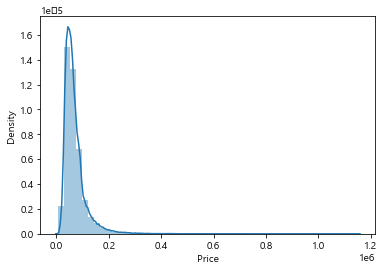

In [47]:
# target y값 분포
f = sns.distplot(df1['Price'])

## 5.1 Linear Regression vs Lasso vs Ridge 계수 비교

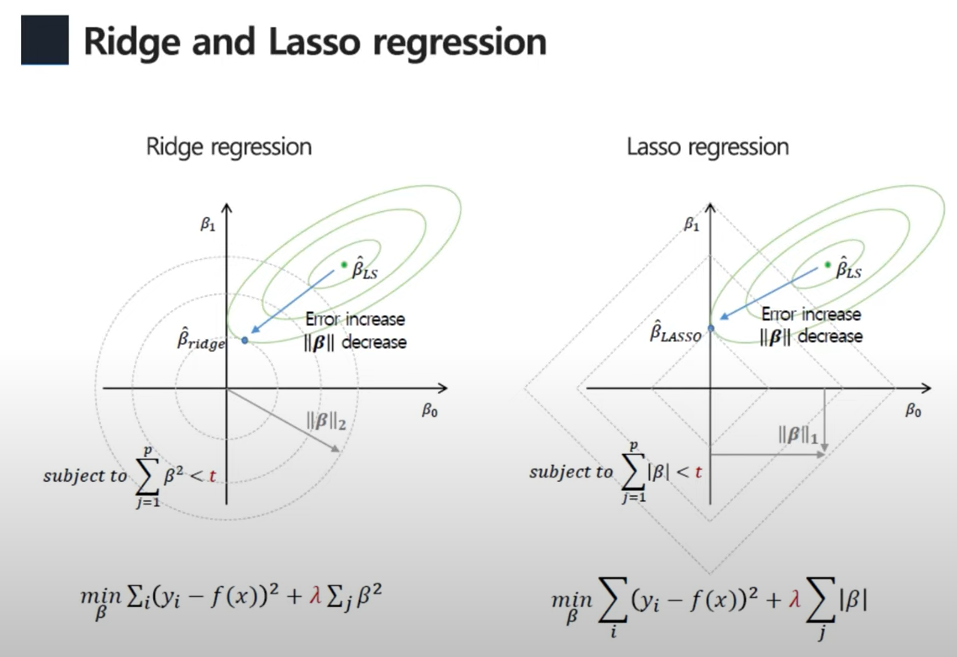

In [42]:
Image("img/nm6.png")

In [ ]:
model_LR = LinearRegression(n_jobs=-1)
model_LR.fit(X_train, y_train)
display(pd.DataFrame(model_LR.coef_, 
                    index=X_test_final.columns, columns = ['Linear Regression 계수']))

ValueError: could not convert string to float: 'FV'

In [ ]:
model_Lasso1 = Lasso(alpha=0.0001, random_state=1)
model_Lasso2 = Lasso(alpha=100.0, random_state=1)
model_Ridge1 = Ridge(alpha=0.0001, random_state=1)
model_Ridge1 = Ridge(alpha=100.0, random_state=1)

model_Lasso1.fit(X_train, y_train)
model_Lasso2.fit(X_train, y_train)
model_Ridge1.fit(X_train, y_train)
model_Ridge2.fit(X_train, y_train)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(sorted(np.abs(model_LR.coef_))[::-1], label='LR', c='gray')
plt.plot(sorted(np.abs(model_Lasso1.coef_))[::-1], label='Lasso alpha = 0.0001')
plt.plot(sorted(np.abs(model_Lasso2.coef_))[::-1], label='Lasso alpha = 100')
plt.plot(sorted(np.abs(model_Ridge1.coef_))[::-1], label='Ridge alpha = 0.0001')
plt.plot(sorted(np.abs(model_Ridge2.coef_))[::-1], label='Ridge alpha = 100')
plt.legend()
plt.ylim((-0.1, 1000)) 
plt.show()

## 5.2 K-fold Cross Validation

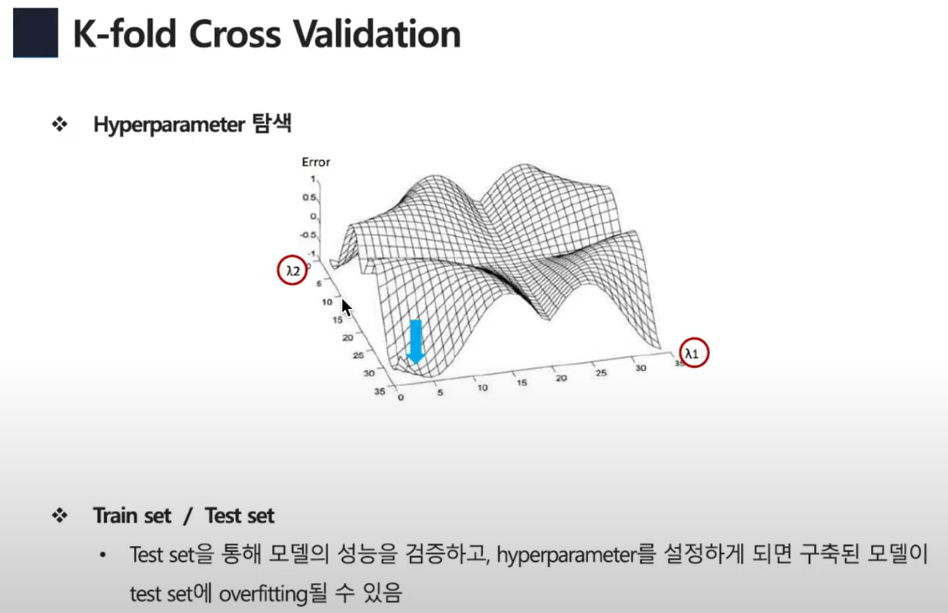

In [60]:
Image("img/nm7.png")

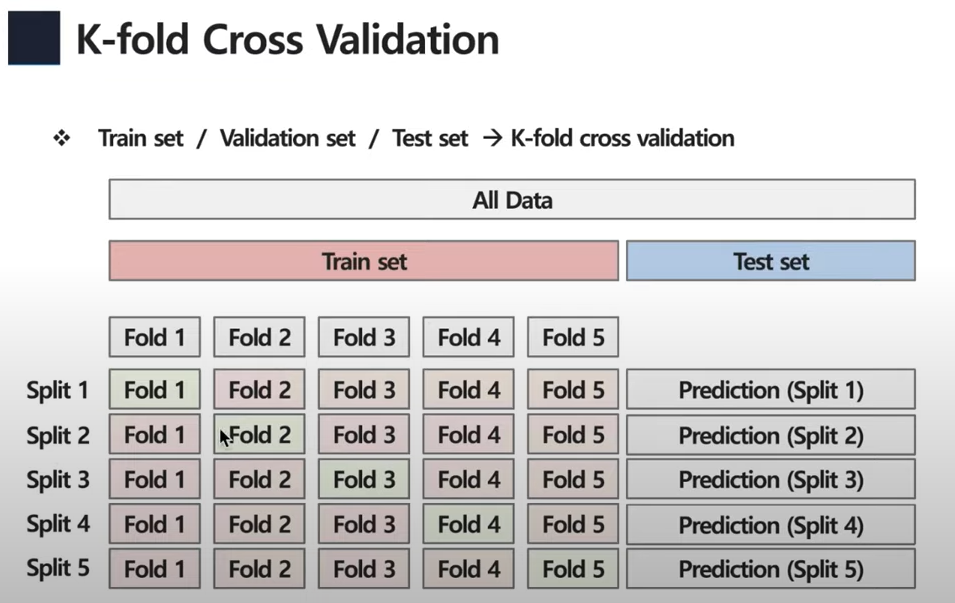

In [61]:
Image("img/nm8.png")

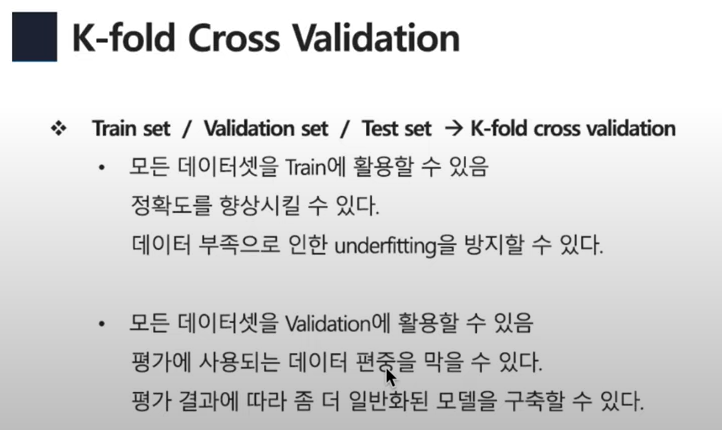

In [62]:
Image("img/nm9.png")

In [63]:
cv = 5
max_iter = 5000

n_trials = 50
def myrange(start, end, step):
    r = start
    while(r<end):
        yield r
        r += step
        
alpha_list = list(reversed([round(i, 2) for i in myrange(0.01,10, 0.1)]))

- 모델 학습

In [ ]:
model_Lasso = LassoCV(alphas=alpha_list, cv=cv, n_jobs=-1, random_state=1, max_iter=max_iter)
model_Lasso.fit(X_train, y_train)

In [ ]:
model_Lasso.alpha_

- 학습된 모델 사용 예측값 출력

In [ ]:
pred_train_LR = model_LR.predict(X_train)
pred_test_LR = model_LR.predict(X_test)
pred_train_Lasso = model_Lasso.predict(X_train)
pred_train_Lasso = model_Lasso.predict(X_test)

- 학습/테스트 예측 결과 성능 출력

In [ ]:
train_rmse_LR = np.sqrt(mean_squared_error(y_train, pred_train_LR))
train_mae_LR = mean_absolute_error(y_train, pred_train_LR)
train_r2_LR = r2_score(y_train, pred_train_LR)

test_rmse_LR = np.sqrt(mean_squared_error(y_test, pred_test_LR))
test_mae_LR = mean_absolute_error(y_test, pred_test_LR)
test_r2_LR = r2_score(y_test, pred_test_LR)

train_rmse_Lasso = np.sqrt(mean_squared_error(y_train, pred_train_LR))
train_mae_Lasso = mean_absolute_error(y_train, pred_train_LR)
train_r2_Lasso = r2_score(y_train, pred_train_LR)

test_rmse_Lasso = np.sqrt(mean_squared_error(y_test, pred_test_LR))
test_mae_Lasso = mean_absolute_error(y_test, pred_test_LR)
test_r2_Lasso = r2_score(y_test, pred_test_LR)

In [ ]:
results = pd.DataFrame(index=['rmse', 'mae', 'r2'], columns = ['LR train', 'LR test', 'Lasso train', 'Lasso test'])

In [ ]:
results.loc['rmse', 'LR train'] = train_rmse_LR
results.loc['mae', 'LR train'] = train_mae_LR
results.loc['r2', 'LR train'] = train_r2_LR

results.loc['rmse', 'LR test'] = test_rmse_LR
results.loc['mae', 'LR test'] = test_mae_LR
results.loc['r2', 'LR test'] = test_r2_LR

results.loc['rmse', 'Lasso train'] = train_rmse_Lasso
results.loc['mae', 'Lasso train'] = train_mae_Lasso
results.loc['r2', 'Lasso train'] = train_r2_Lasso

results.loc['rmse', 'Lasso test'] = test_rmse_Lasso
results.loc['mae', 'Lasso test'] = test_mae_Lasso
results.loc['r2', 'Lasso test'] = test_r2_Lasso

- overfitting 막으면서 일반화 성능이 높아짐

In [ ]:
results

## 5.3 K-fold Cross Validation (k폴드 교차검증)으로 하이퍼 파라미터 찾기

In [ ]:
# dict with optimal models
models = {}

# find optimal value of alpha
n_trials = 20
alpha_list = 10 ** np.linspace(-3, 3, n_trials)

# number of folds for cross validation
cv=5

# find optimal value of l1 (for ElasticNet)
alpha_list = list(reversed([round(i, 2) for i in myrange(0.01, 10, 0.1)]))
l1_list = list(reversed([round(i, 2) for i in myrange(0, 1, 0.1)]))

max_iter = 5000

In [ ]:
# find optimal Lasso model
model = LassoCV(alphas=alpha_list, cv=cv , n_jobs=-1, random_state =1 , max_iter=max_iter)
model.fit(X_train, y_train)
models['Lasso'] = Lasso(alpha=model.alpha_, max_iter=max_iter)

In [ ]:
# find optimal Ridge model
model = RidgeCV(alphas=alpha_list, cv=cv)
model.fit(X_train, y_train)
models['Ridge'] = Ridge(alpha=model.alpha_)

In [ ]:
# find optimal ElasticNet model
model = ElasticNetCV(alphas=alpha_list, l1_ratio = l1_list, 
                     cv=cv, random_state=1, n_jobs=-1, max_iter=max_iter)
model.fit(X_train, y_train)
models['ElasticNet'] = ElasticNet(alpha=model.alpha_, l1_ratio=model.l1_ratio_, max_iter=max_iter)

In [ ]:
for name in models.keys():
    print(models[name])
    print('-'*100)

## 5.4 모델 비교 선택

In [ ]:
kf = KFold(cv, shuffle=True, random_state=1)
kf

In [ ]:
score = {}
for name in models.key():
    # save score for each model
    if name not in score:
        score[name] = []
        
    # 모델
    reg = models[name]
    for i_train, i_valid in kf.split(X_train):
        # 학습
        reg.fit(X_train[i_train], y_train[i_train])
        # 예측
        y_pred = reg.predict(X_train[i_valid])
        RMSE = np.sqrt(mean_squared_error(y_trainn[i_valid], y_pred))
        socre[name].append(MSE)

In [ ]:
score

In [ ]:
results = pd.DataFrame(score)
results

In [ ]:
ax = result.plot.bar()
pd.concat([results.mean(), results.std()], axis =1, keys=['mean', 'std'])

## 5.5 최종 모델 학습, 결과 출력, 성능 확인

In [ ]:
model = models['ElasticNet'].fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

In [ ]:
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
print(f'train rmse : {rmse_train:.4f}')
print(f'test rmse : {rmse_test :.4f}')

In [ ]:
r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)
print(f'train rmse : {r2_train:.4f}')
print(f'test rmse : {r2_test :.4f}')

### 예측 결과 plotting

In [ ]:
plt.figure(figsize=(8,8))
plt.title('실제값 vs. 모델 출력값', fontsize=16)
plt.scatter(y_train, pred_train, c='red', alpha=0.5) # alpha 투명도 0일수록 투명
plt.scatter(y_test, pred_test, c='blue', alpha=0.5)
plt.plot(y_test, y_test, c='gray')
plt.plot(y_train, y_train, c='gray')
plt.xlabel('실제값', size=10)
plt.ylabel('모델 출력값', size=10)
plt.show()

### 계수값을 변수 중요도로 생각하기

In [ ]:
model = models['ElasticNet'].fit(X_train, y_train)

coef_df = pd.DataFrame(model.coef_.reshape(-1, 1), index = X_test_final.columns, columns=['coefficients'])
coef_df.to_csv('coef_csv')
coef_df

In [ ]:
# Sort : descending order 
coefficients = np.abs(coef_df.coefficients)
index = np.argsort(coefficients)[::-1]
print(index)

In [ ]:
importance = coefficients[index]
columns = [list(coef_df.index)[i] for i in index]

In [ ]:
importance = importance[importance>0]

In [ ]:
num_print = 20

plt.figure(figsize=(10,3))
plt.title('Feature Importances = ABS(coefficients)')
plt.bar(range(num_print), 
       importance[:num_print],
       align='center')
plt.xticks(range(num_print), columns[:num_print], rotation=90, fontsize=11)
plt.show()